# Viscosity of a magma

The viscosity of a magma depends on composition and temperature. In this notebook, we will focus on the effect of temperature.

Several equations allow taking into account of this effect. Among those, the MYEGA formalism has been fairly sucessful. It express the viscosity of a magma, $\eta$, as a function of its glass transition temperature $T_g$ (K), its fragility $m$ (no unit) and a high temperature limit $A_e$ (Pa s):

$$\log \eta = A_e + \frac{T_g}{T}(12-T_g)\exp [(\frac{m}{12-T_g}-1)(\frac{T_g}{T}-1)]$$

with T the temperature in K.

In this notebook, we have new data regarding the viscosity of the phonolite magma that have been erupted in past eruptions at Mayotte. We will fit them using this equation. The goal is to find a set of parameters $T_g$ , $m$ and $A_e$ that work well for this problem.

**This is a real worl problem, published in**
*Verdurme P., Le Losq C., Chevrel O., et al. (2023) Viscosity of crystal-free silicate melts from the active submarine volcanic chain of Mayotte. Chemical Geology 620, 121326.*

# Data import and visualization

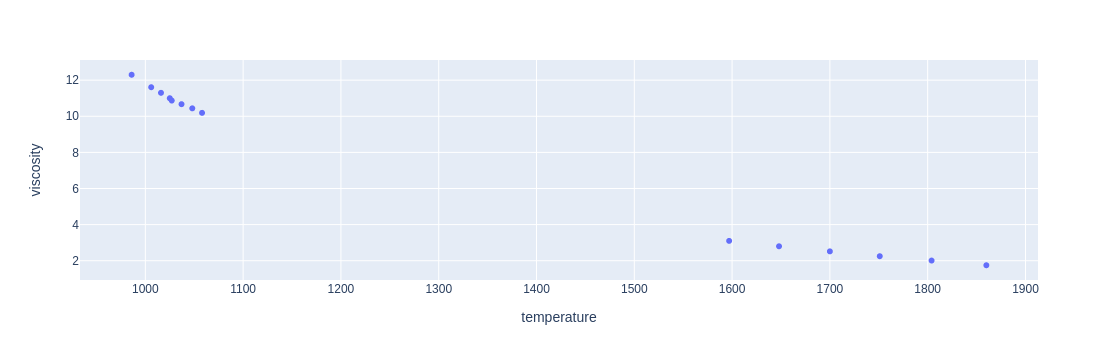

In [1]:
import numpy as np
import pandas as pd
import scipy

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly" # make plotly the backend for pandas plot


data = pd.read_csv("Verdurme_2023_DR07_phonolite.csv", header=0, names=["temperature","viscosity"])

# errors on the data are of 0.03 log10 Pa s above 8 log10 Pa s
# we will set them at 0.01 at viscosity lower than 6 log10 Pas
data["ese"] = 0.03
data.loc[data.loc[:,"viscosity"] < 6.0,"ese"] = 0.01

data.plot.scatter(x="temperature", y="viscosity")

# Define the foward model

And we make a first attempt to plot its values with initial parameters set by hand.

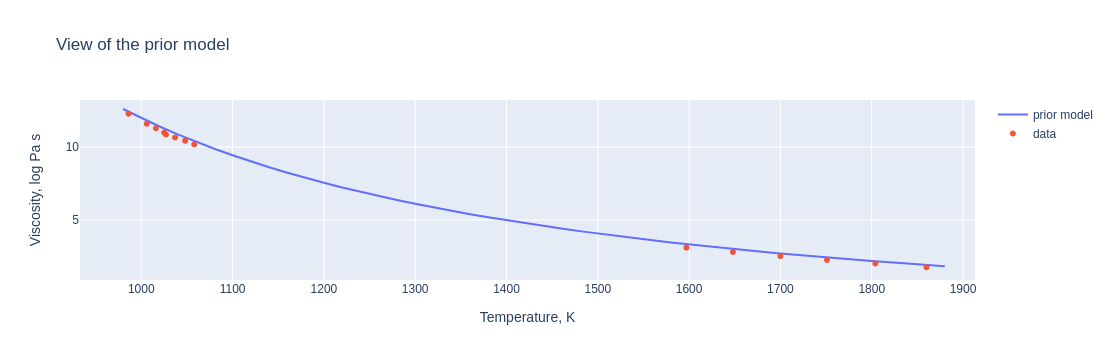

In [2]:
def forward_model(T,Ae,Tg,m):
    """returns the viscosity given Ae, Tg and m following the MYEGA formalism
    
    Parameters
    ----------
    T : temperature(s), K
    
    Ae : high temperature limit, Pa s
    
    Tg : glass transition temperature, K
    
    m : melt fragility (derivative of the viscosity versus T curve at Tg)
    
    Returns
    -------
    n : viscosity at T
    """
    exp_part = np.exp((m/(12.0-Ae)-1.0)*(Tg/T-1.0))
    out = Ae + (Tg/T)*(12.0-Ae)*exp_part
    return out

# this is a temperature scale for interpolation
temperature_interpolation = np.arange(980, 1900, 20.0)

# this is calculated values with some prior idea
# given the first plot above, 
# Tg should be around 1000
# m  probably around 30 (domain knowledge, Le Losq et al. 2015)
# Ae around -3.5 (domain knowledge, Giordano and Russel 2004)
Ae_prior = -3.5
m_prior = 30.
Tg_prior = 1000.
y_prior = forward_model(temperature_interpolation, Ae_prior, Tg_prior, m_prior)

fig = make_subplots(rows=1, cols=1)
fig.add_trace(
    go.Scatter(x=temperature_interpolation, y=y_prior, name="prior model"),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=data.temperature, y=data.viscosity, name="data", mode='markers'),
    row=1, col=1)


fig.update_layout(
    title="View of the prior model",
    xaxis_title="Temperature, K",
    yaxis_title="Viscosity, log Pa s",)

# Problem resolution

In [3]:
def lognormal(x,mu,std):
    var = std**2
    return -0.5*((x-mu)**2/var + np.log(2.0*np.pi*var))

def logprior(theta):
    """log prior probability function for the parameters
    
    This implementation uses a uniform distribution
    
    Parameters
    ==========
    theta : list
        the parameters
        
    Returns
    =======
    logprob_prior : the estimated probability of the prior values
    
    """
    Ae, Tg, m = theta
    
    # Any value outside the ranges below will return an -np.inf prior (so a probability of 0 = model not valid)
    if -20 < Ae < 0 and m > 0 and Tg > 0:
        # Uniform distribution for the prior of Ae so we return 0
        P_Ae_prior = 0.0
        # Same for the fragility m
        P_m_prior = 0.0
        # Normal distribution for the prior on Tg, centered around 1000 K with an important error of 50K
        P_Tg_prior = 0.0#lognormal(Tg, 1000.0, 50.0)    
        
        prior_probability = P_Ae_prior + P_m_prior + P_Tg_prior
        return prior_probability
    else:
        return -np.inf
    
def loglike(theta,x,y,yerr):
    """log likelyhood function
    
    This implementation uses the log of a gaussian distribution
    
    Parameters
    ==========
    theta : list
        the parameters
    x : ndarray
        here x is the temperature
    y : ndarray
        the viscosity observations
    yerr : ndarray
        the errors on the viscosity observations
        
    Returns
    =======
    ln_likely : float
        the estimated likelyhood of the a model compared to observations
    
    """
    model = forward_model(x,*theta)
    ln_likely = np.sum(lognormal(y,model,yerr))
    return ln_likely

def logjoint(theta, x, y, yerr):
    """joint probability function
    
    This implementation uses the log of a gaussian distribution
    
    Parameters
    ==========
    theta : list
        the parameters
    x : ndarray
        the X variable: here the temperature
    y : ndarray
        the y observations: here the viscosity
    yerr : ndarray
        errors on y
        
    Returns
    =======
    ln_prob : float
        the total likelyhood of a model compared to observations
    
    """
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(theta,x,y,yerr)

def mcmc(x, y, yerr, theta_start, scales, nb_iter):
    """MCMC Metropolis Hasting function to fit simple data
    
    Parameters
    ==========
    x : ndarray
        the x variable: here the temperature
    y : ndarray
        the y observations: here the viscosity
    yerr : ndarray
        errors on y
    theta_prior : list
        the estimates of model parameters
    scales : list
        scaling factor for perturbating the parameters
    nb_iter : int
        number of iterations to perform = number of sampled models
        
    Returns
    =======
    theta_record : ndarray, shape = (nb_iter,size(theta_prior))
        the estimates of model parameters
    logrecord : 1D array
        the log probabilities of the nb_iter models
    acceptance_rate : 1D array
        the acceptance rate for each parameter
        
    """
    
    # how many parameters do we have?
    nb_params = len(theta_start)
    
    # creatign arrays
    logrecord = np.zeros(nb_iter)
    theta_record = np.zeros((nb_iter,nb_params))
    
    # to calculated acceptance rate
    accepted = 0
    
    # the starting parameters and logrecord
    logrecord[0] = logjoint(theta_start,x,y,yerr)
    theta_record[0,:] = theta_start
    
    i = 1
    while i < nb_iter:
        
        # we perturbate parameters
        theta_0 = theta_record[i-1,:] + scales*np.random.randn(3)
        # we calculate the associated log prob
        logprob_theta0 = logjoint(theta_0,x,y,yerr)
        # and the ratio (subtraction as we are in log) with the old logprob
        alpha = logprob_theta0 - logrecord[i-1]
        
        if np.exp(alpha) > np.random.rand(): # if our probability is actually higher than the previous
            logrecord[i] = logprob_theta0
            theta_record[i,:] = theta_0
            accepted = accepted + 1
        else: # otherwise we stay at the same position
            logrecord[i] = logrecord[i-1]
            theta_record[i,:] = theta_record[i-1,:]
            
        i += 1 # incrementing i as well as the number of tested models
            
    # calculation of acceptance rates
    acceptance_rate = accepted/(nb_iter-1)
    
    # results are returned
    return theta_record, logrecord, acceptance_rate  

In [4]:
theta_start = [-3.5, 1000.0, 30.] # starting values of parameters
if logprior(theta_start) != -np.inf:
    print("Model viable")
else: 
    print("Model not viable, will result in a 0 posterior probability")

Model viable


# Go to the top of the hill

In [5]:
# Find the maximum likelihood value.
import scipy.optimize as op

chi2 = lambda *args: -2 * logjoint(*args)
result = op.minimize(chi2, theta_start, args=(data.temperature.values, data.viscosity.values, data.ese.values))
print(result)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -55.795297013471426
        x: [-2.900e+00  9.932e+02  3.197e+01]
      nit: 27
      jac: [ 1.369e-04  4.864e-05 -2.193e-05]
 hess_inv: [[ 6.389e-05 -2.718e-05 -5.503e-05]
            [-2.718e-05  1.210e-05  2.255e-05]
            [-5.503e-05  2.255e-05  5.353e-05]]
     nfev: 339
     njev: 80


/home/charles/anaconda3/envs/pymc_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning:

invalid value encountered in subtract



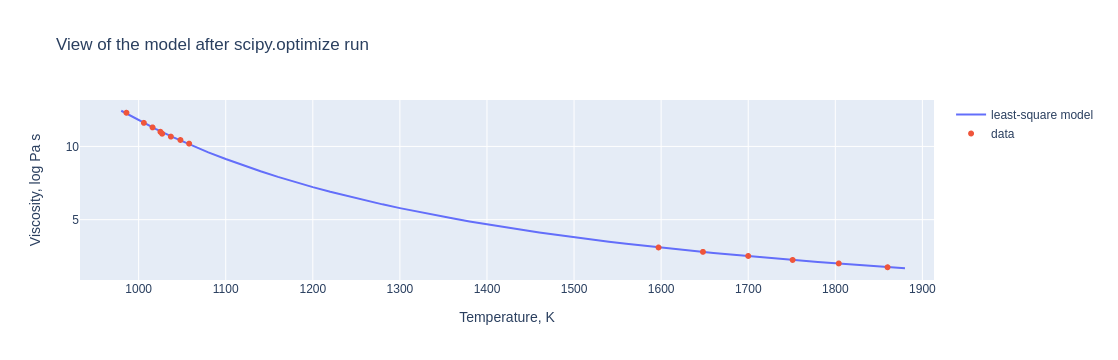

In [6]:
#Result is a dictionary, the best parameters are the x values.
popt = result['x'][:]

# we calculate the best estimate
y_pred_minimize = forward_model(temperature_interpolation, *popt) # parameter unwrapping (*popt) works only in Python 3

fig = make_subplots(rows=1, cols=1)
fig.add_trace(
    go.Scatter(x=temperature_interpolation, y=y_pred_minimize, name="least-square model"),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=data.temperature, y=data.viscosity, name="data", mode='markers'),
    row=1, col=1)


fig.update_layout(
    title="View of the model after scipy.optimize run",
    xaxis_title="Temperature, K",
    yaxis_title="Viscosity, log Pa s",)


In [7]:
scales = np.array([0.6e-1,0.1e0,0.1e-1])
scales_test = scales*np.random.randn(3)
print("Parameters starting value: "+str(theta_start)) 
print("Perturbations: "+str(scales_test))


Parameters starting value: [-3.5, 1000.0, 30.0]
Perturbations: [-0.02877461 -0.00851621 -0.00539787]


In [8]:
nb_iter= 1000000
nb_chains = 2

chains_theta = []
chains_logrecord = []
chains_acceptance = []

for i in range(nb_chains):
    print("Running chain "+str(i))
    theta_mcmc, logrecord_mcmc, acceptance_rate = mcmc(data.temperature.values, 
                                                       data.viscosity.values, 
                                                       data.ese.values,
                                                       theta_start,
                                                       scales,
                                                       nb_iter)
    chains_theta.append(theta_mcmc)
    chains_logrecord.append(logrecord_mcmc)
    chains_acceptance.append(acceptance_rate)
    


Running chain 0
Running chain 1


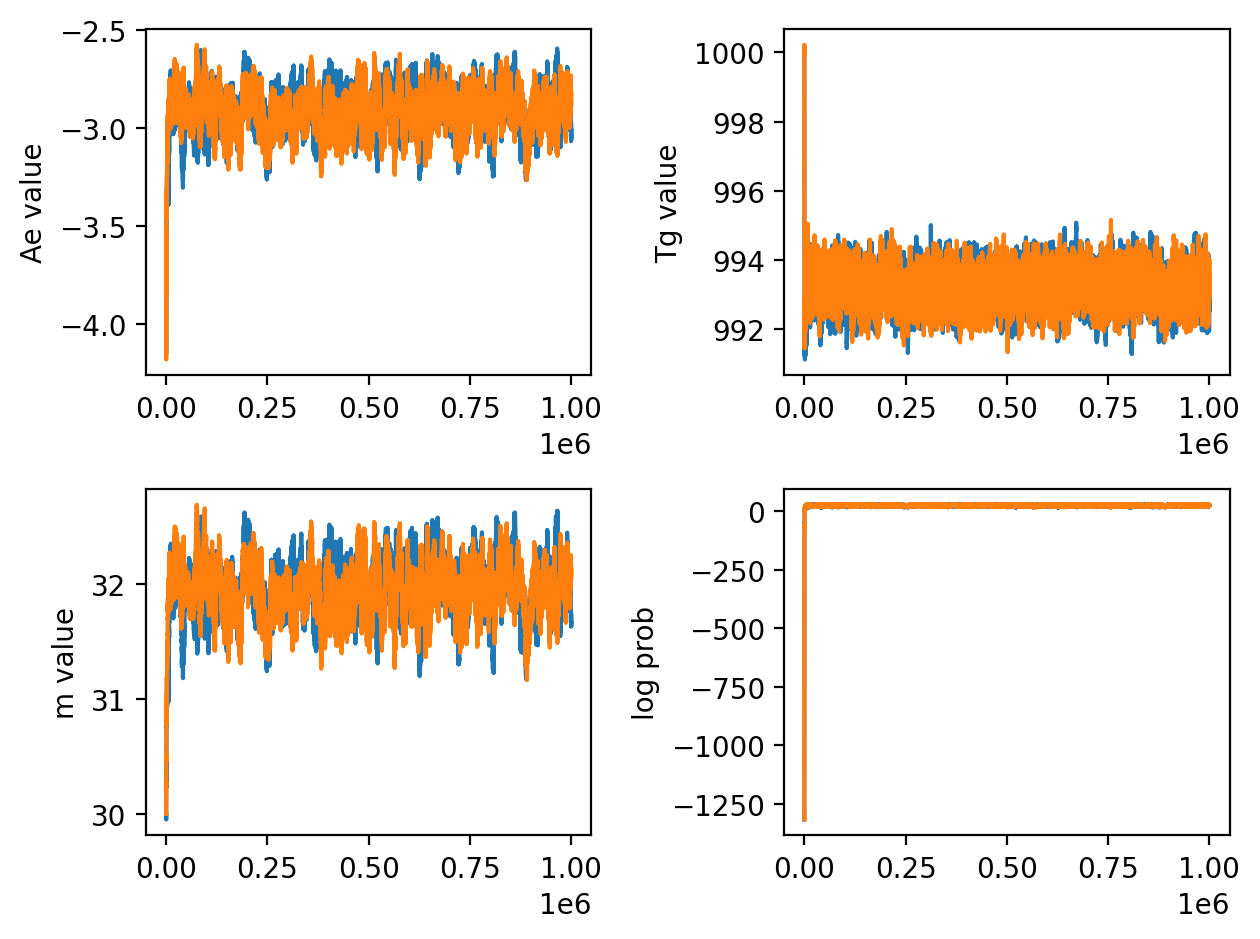

In [9]:
plt.figure(dpi=200)

plt.subplot(2,2,1)
for i in range(nb_chains):
    plt.plot(chains_theta[i][:,0])
plt.ylabel("Ae value")

plt.subplot(2,2,2)
for i in range(nb_chains):
    plt.plot(chains_theta[i][:,1])
plt.ylabel("Tg value")

plt.subplot(2,2,3)
for i in range(nb_chains):
    plt.plot(chains_theta[i][:,2])
plt.ylabel("m value")

plt.subplot(2,2,4)
for i in range(nb_chains):
    plt.plot(chains_logrecord[i])
plt.ylabel("log prob")


plt.tight_layout()

We check acceptance for each chain

In [10]:
print(chains_acceptance)

[0.24512424512424513, 0.2446762446762447]


In [11]:
Burnin = 200000
thin = 100

samples_MH=[]
for i in range(nb_chains):
    samples_MH.append(chains_theta[i][Burnin:thin:-1,:])
samples_MH = np.concatenate(samples_MH)

D_mcmc = np.median(samples_MH[:,0])
c0_mcmc = np.median(samples_MH[:,1])
nb_drawn_samples = len(samples_MH)

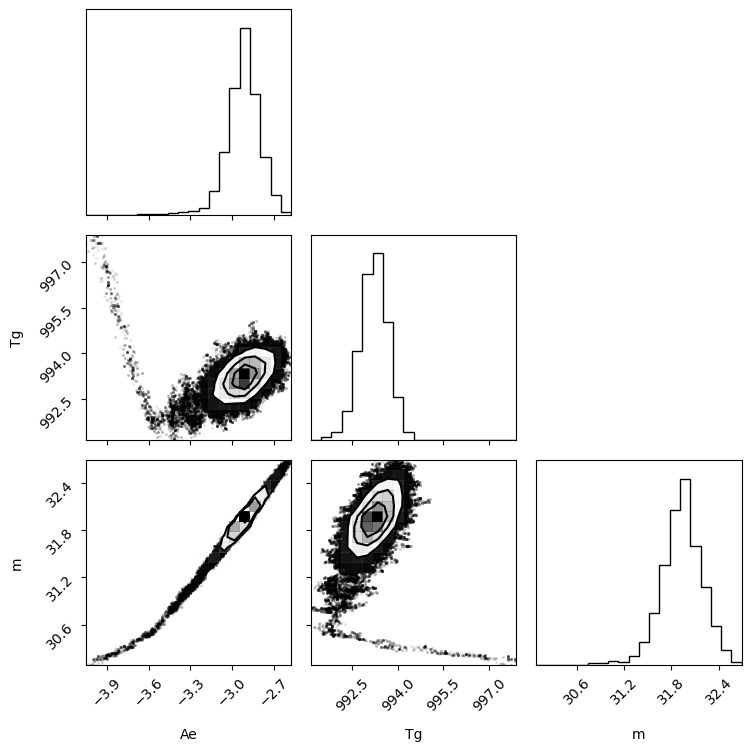

In [12]:
import corner
labels = ['Ae','Tg','m']
fig_mh = corner.corner(samples_MH,labels=labels)
plt.tight_layout()

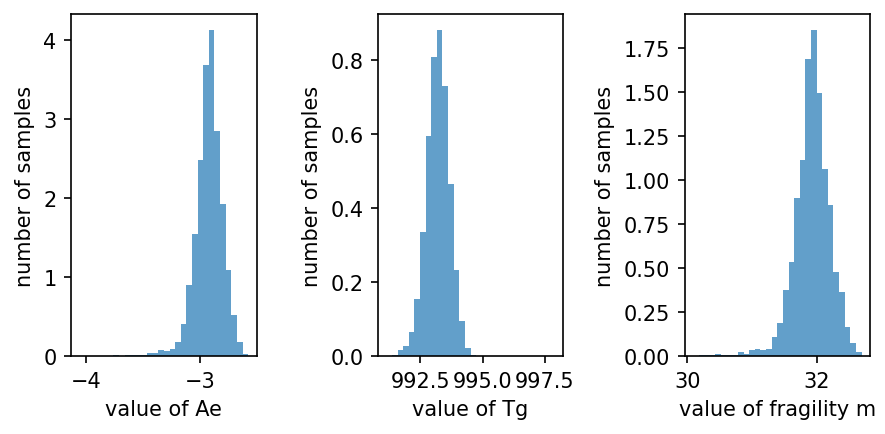

In [13]:
plt.figure(figsize=(6,3),dpi=150)
plt.subplot(1,3,1)
plt.hist(samples_MH[:,0],
                 alpha=0.7,bins=30,density=True,label="MH")
plt.xlabel("value of Ae")
plt.ylabel("number of samples")

plt.subplot(1,3,2)
plt.hist(samples_MH[:,1],
                 alpha=0.7,bins=30,density=True)
plt.xlabel("value of Tg")
plt.ylabel("number of samples")

plt.subplot(1,3,3)
plt.hist(samples_MH[:,2],
                 alpha=0.7,bins=30,density=True)
plt.xlabel("value of fragility m")
plt.ylabel("number of samples")
plt.tight_layout()
plt.show()

We notice above that the distributions of Ae and m are slightly non-Gaussian. So here the sampling with MCMC is a good option to have a good idea of errors.

As we have many parameter samples, we can predict many models and see their position in the plot of distance versus observed concentration.

A high probability will be indicated by many models overlying. Visually, we can use the alpha option of matplotlib to set this up.

Text(0, 0.5, 'Viscosity, log Pa s')

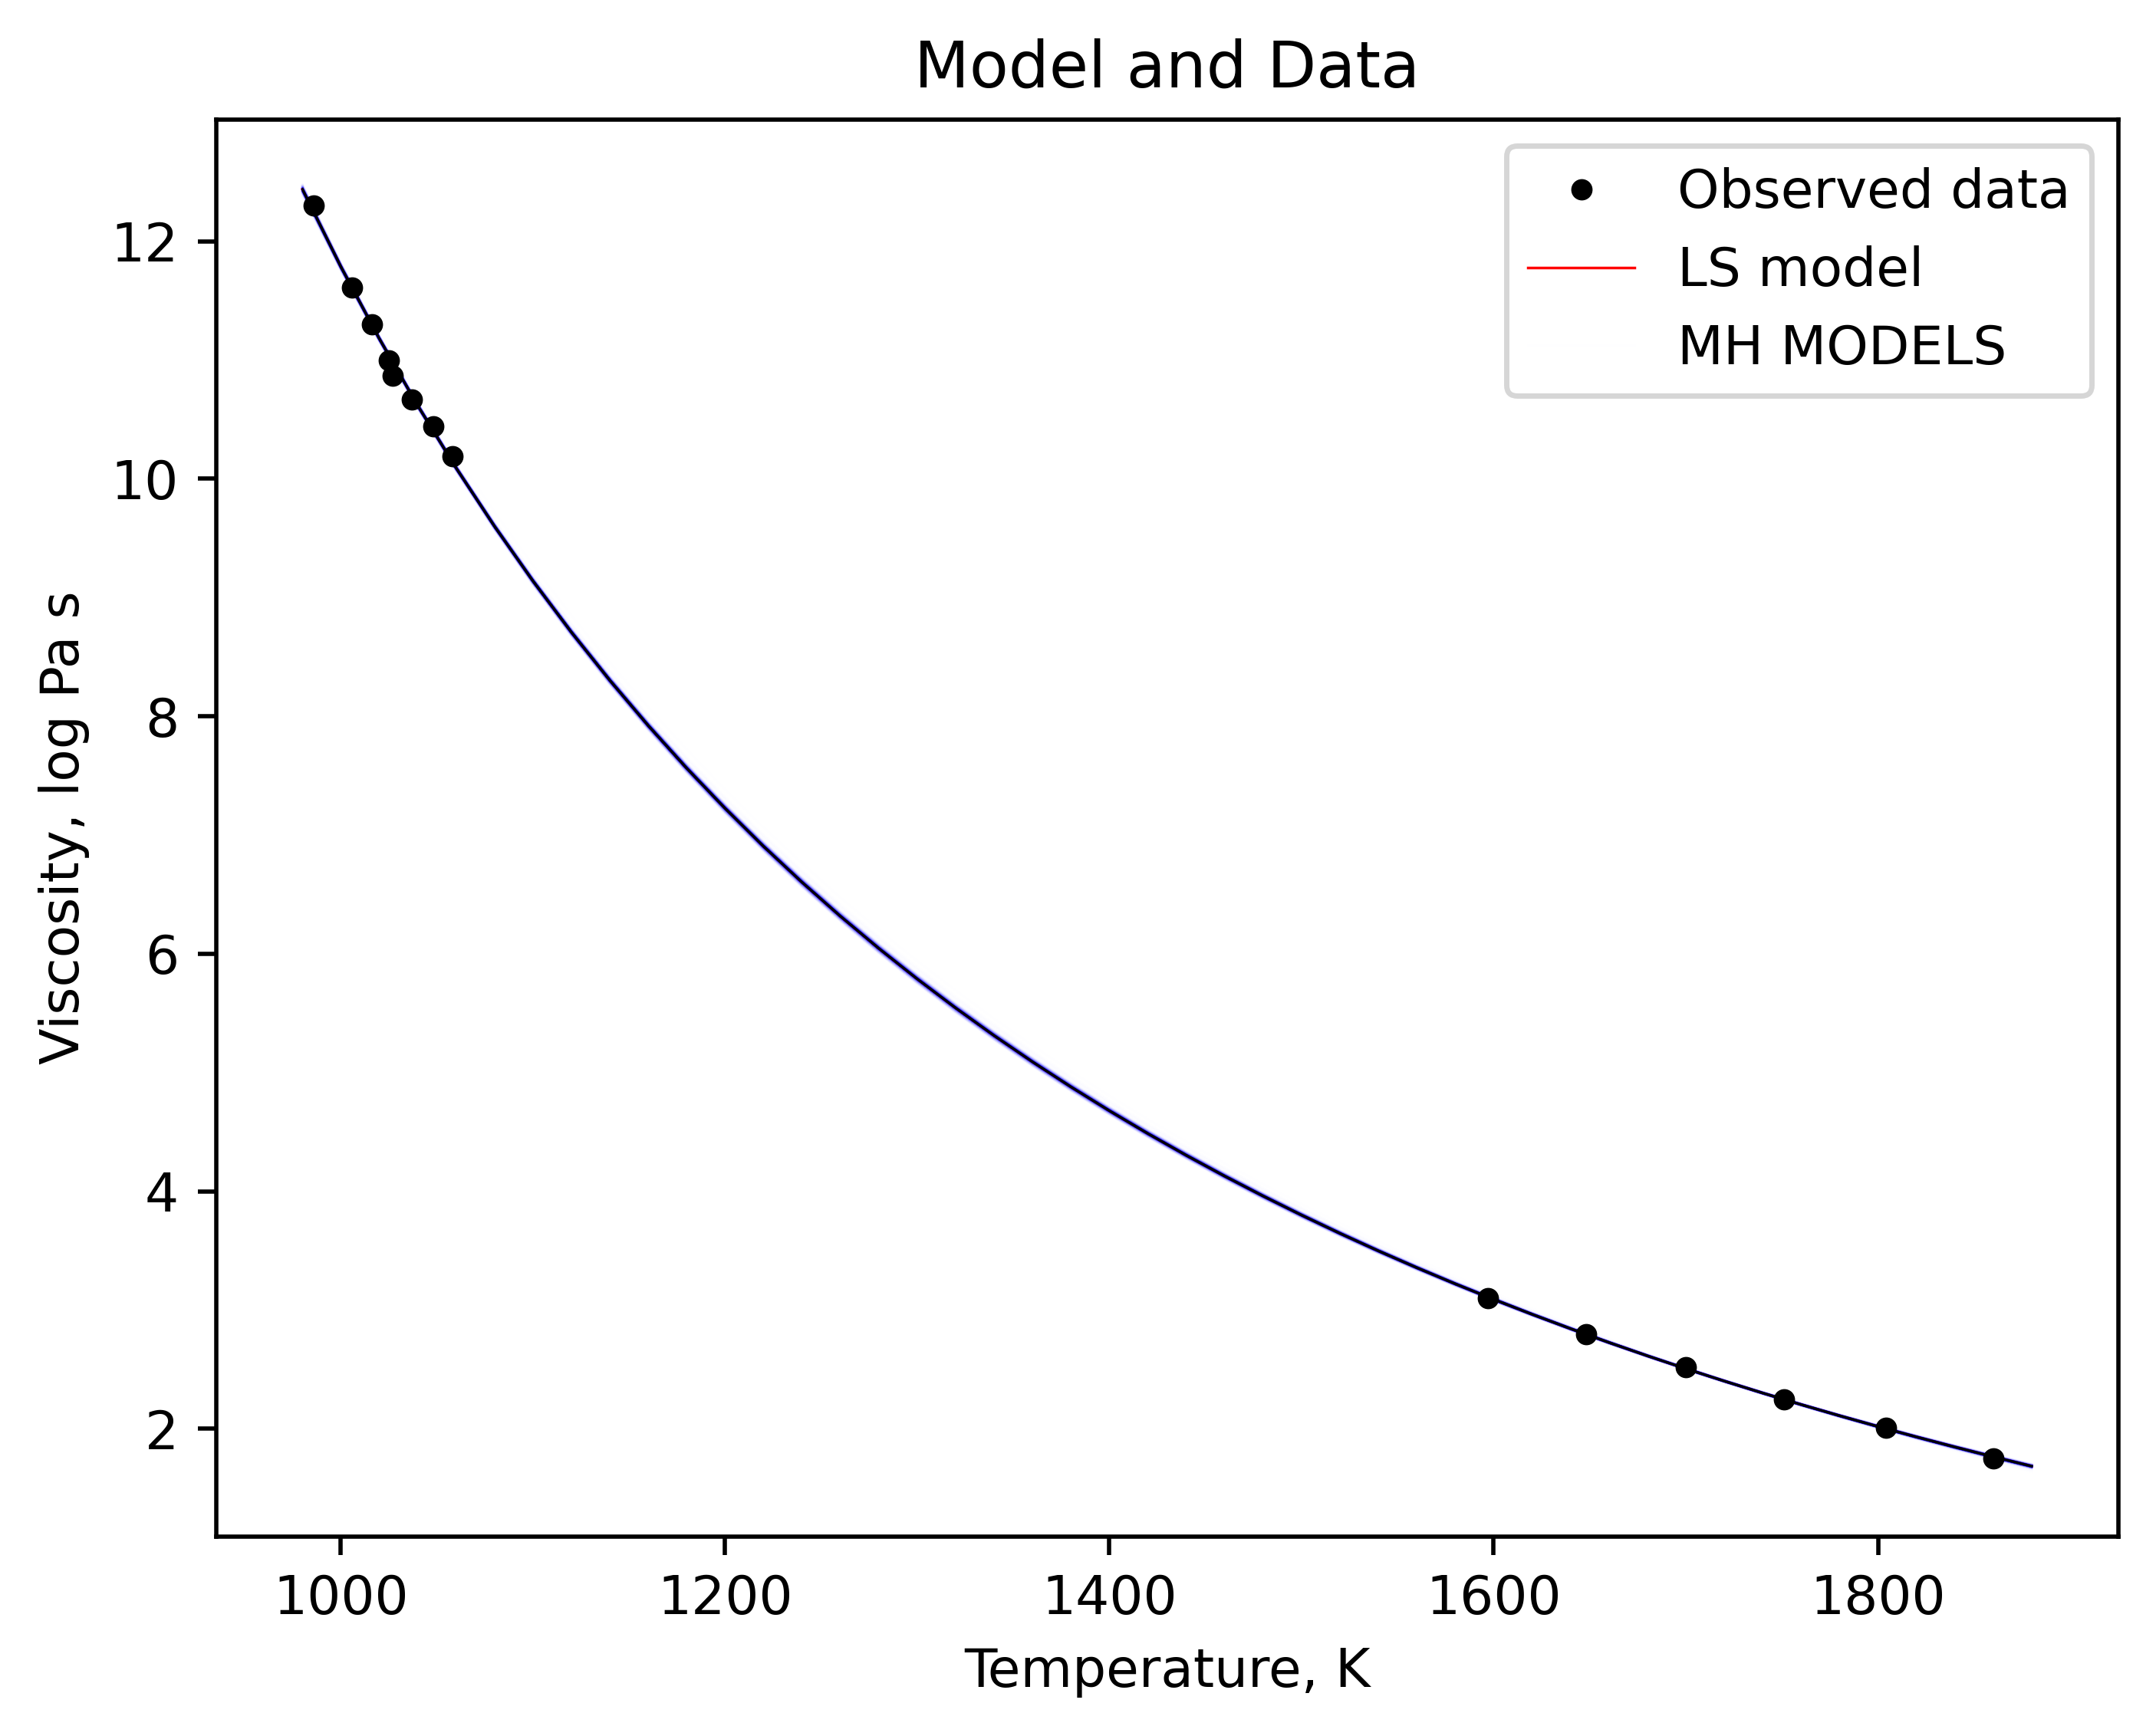

In [14]:
models = np.zeros((len(temperature_interpolation),500))

for i in range(500):
    gen_pick = np.random.randint(0,len(samples_MH))
    models[:,i] = forward_model(temperature_interpolation,*samples_MH[gen_pick,:])

plt.figure(dpi=500)
plt.plot(data.temperature,data.viscosity,"k.",label="Observed data")
plt.plot(temperature_interpolation,y_pred_minimize,"r-",label="LS model", linewidth=0.5)
plt.plot(temperature_interpolation,models[:,0],"b-",alpha=0.005,label="MH MODELS", linewidth=0.5)
plt.legend()
plt.plot(temperature_interpolation,models[:,1:],"b-",alpha=0.005, linewidth=0.5)
plt.title("Model and Data")

plt.xlabel("Temperature, K")
plt.ylabel("Viscosity, log Pa s")

Text(0, 0.5, 'Viscosity, log Pa s')

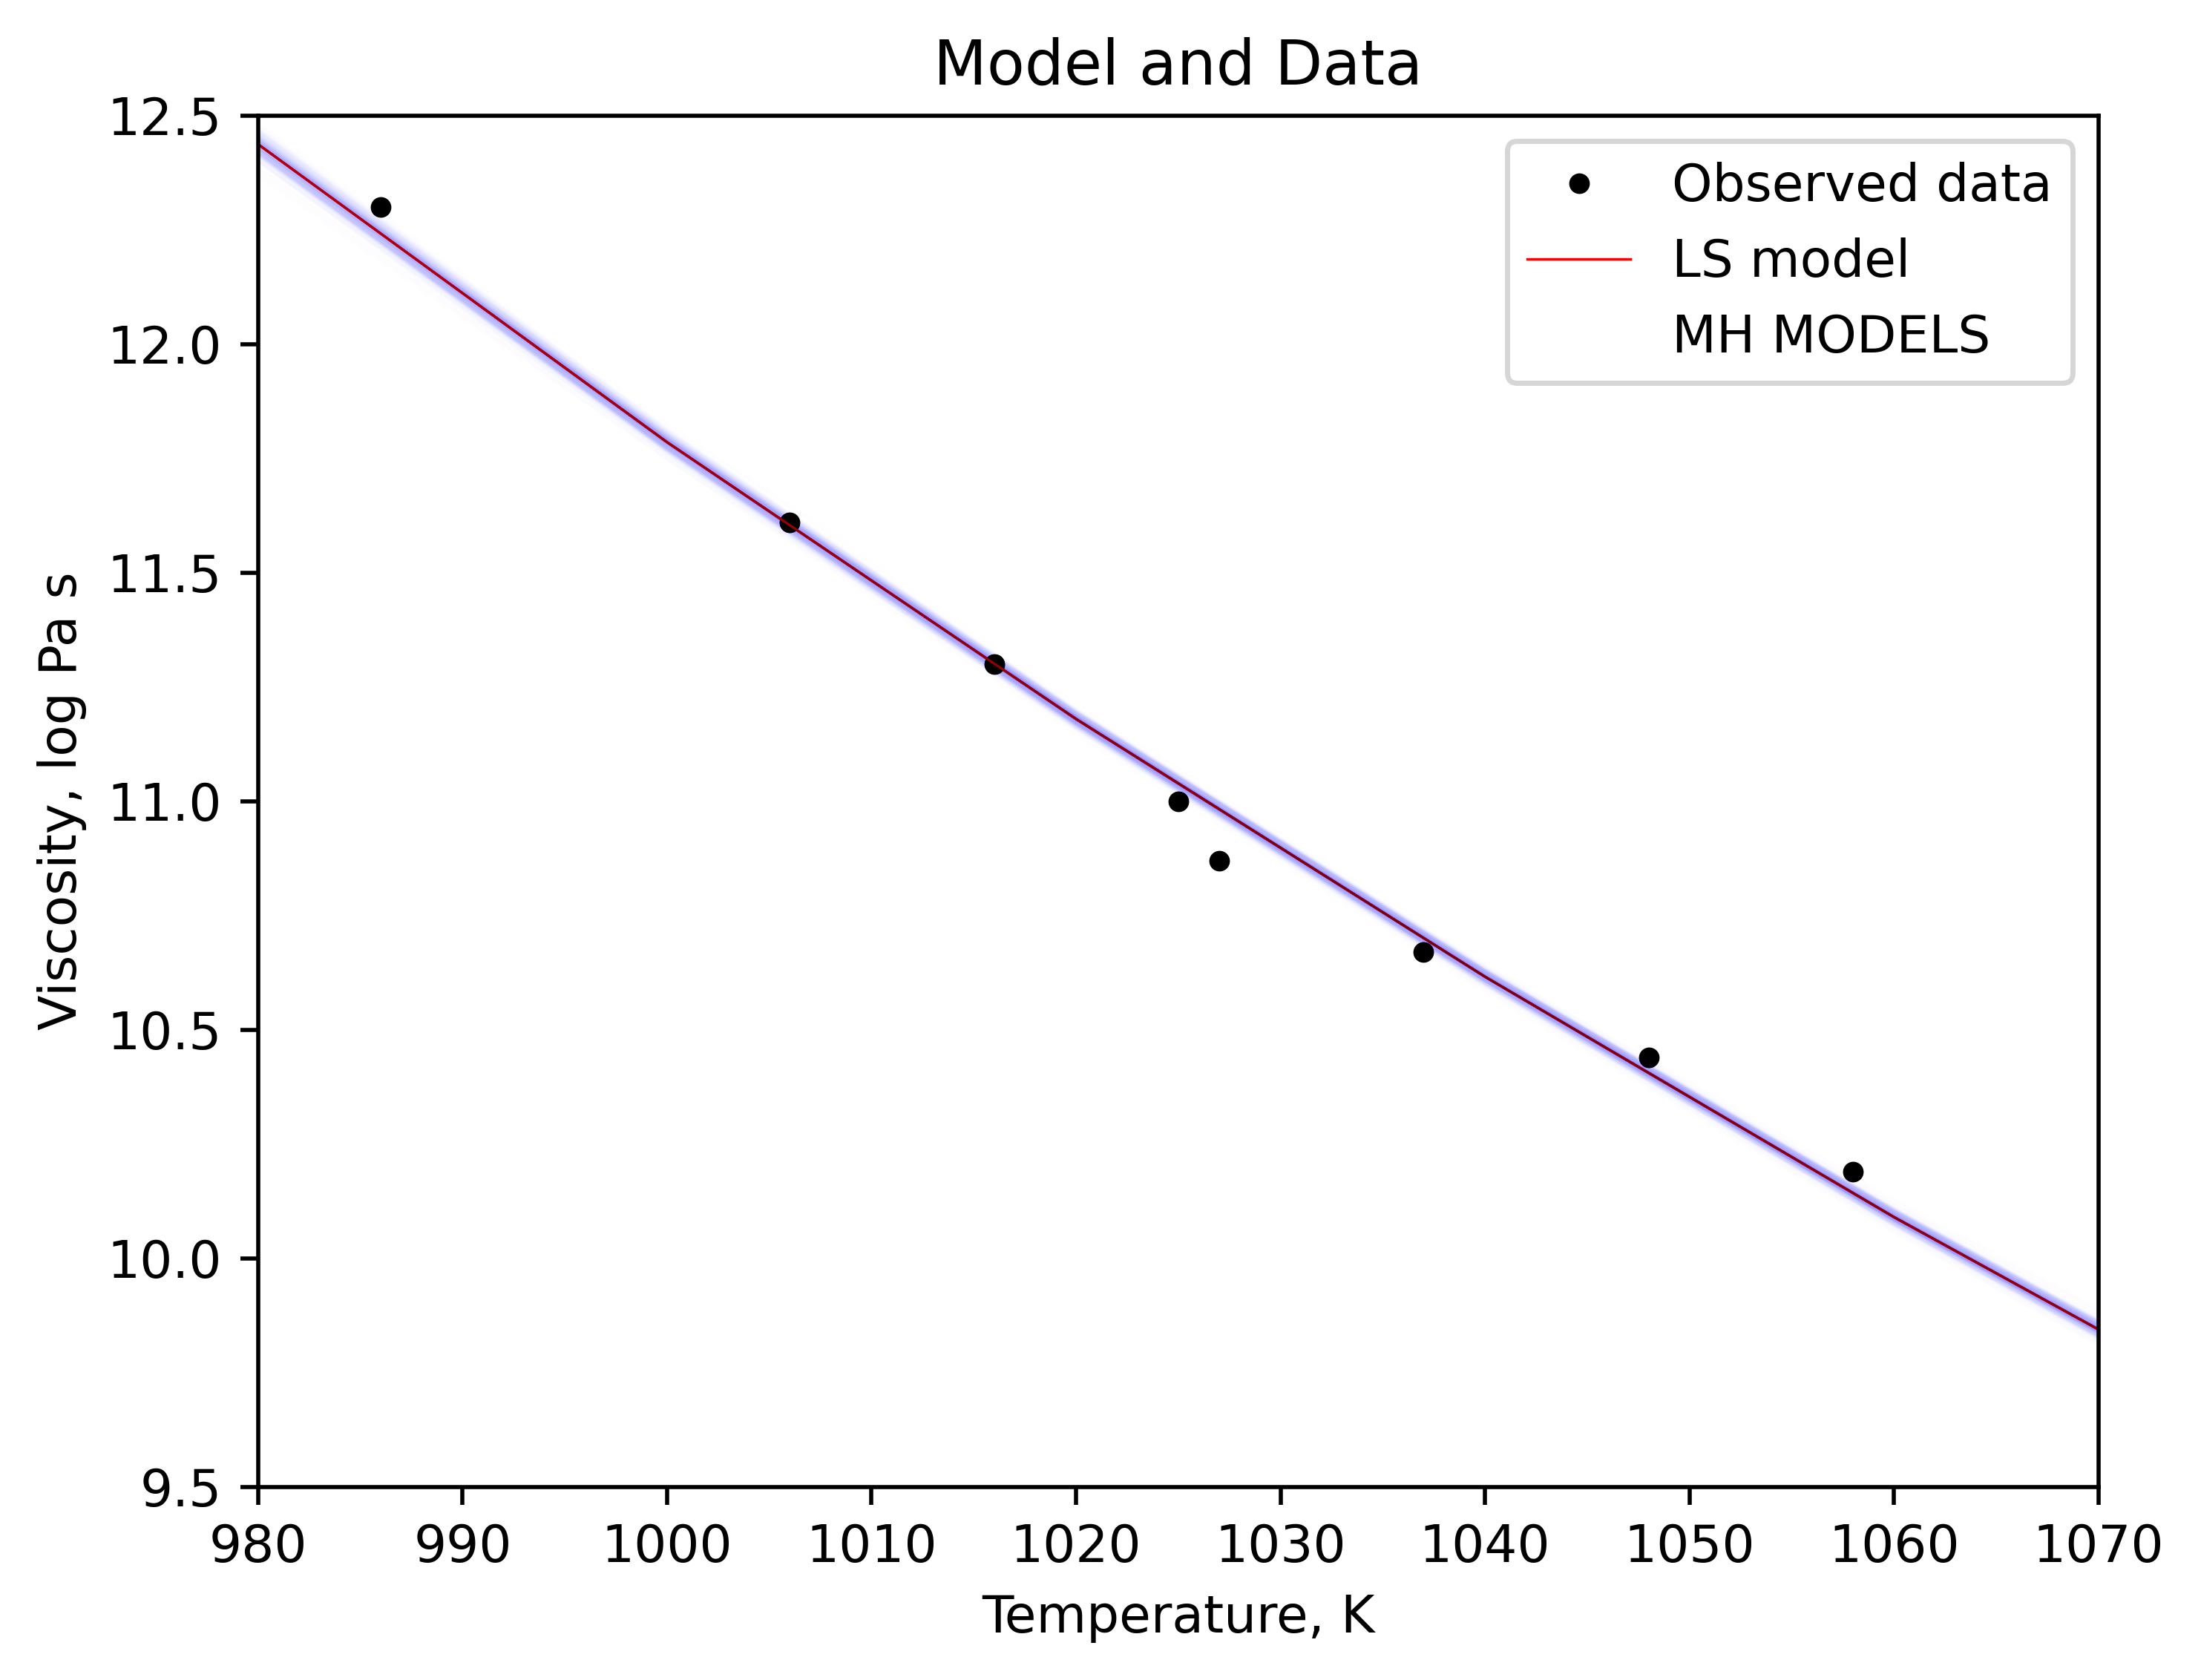

In [15]:
plt.figure(dpi=500)
plt.plot(data.temperature,data.viscosity,"k.",label="Observed data")
plt.plot(temperature_interpolation,y_pred_minimize,"r-",label="LS model", linewidth=0.5)
plt.plot(temperature_interpolation,models[:,0],"b-",alpha=0.005,label="MH MODELS", linewidth=0.5)
plt.legend()
plt.plot(temperature_interpolation,models[:,1:],"b-",alpha=0.005, linewidth=0.5)
plt.title("Model and Data")
plt.xlim(980, 1070)
plt.ylim(9.5,12.5)

plt.xlabel("Temperature, K")
plt.ylabel("Viscosity, log Pa s")

# BONUS: another tool > PyMC

In the other notebook, we saw the use of EMCEE instead of our custom MH algorithm.

Here, I provide the code using [PyMC](https://www.pymc.io/welcome.html), another tool for probabilistic programming.


In [16]:
import arviz as az
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.1


In the code below, we define the prior on the model parameter, and we sample using a normal likelihood

All this is handled easily by PyMC. An introductory example is given here: https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html

In [17]:
#we get the temperatures in a dedicated array
temperature_data = data.temperature.values

# We define a model object
basic_model = pm.Model()

# In this object we add priors, the calculation and the likelihood
with basic_model:
    # Priors for unknown model parameters
    # Here we will use Normal priors as we start to have a good idea of the good values
    # Other distributions are available, look at PyMC help for this
    Ae = pm.Normal("ae", mu=-2.9, sigma=0.5)
    Tg = pm.Normal("tg", mu=993, sigma=10)
    m = pm.Normal("m", mu=31., sigma=2.)

    # We will perform Hamiltonian MCMC, so the error will be infered by the MCMC algorithm
    # this is why it appears here in the code, and is not provided
    sigma = pm.HalfNormal("sigma", sigma=0.03)
    
    # Expected value of outcome
    mu = Ae + (Tg/temperature_data)*(12.0-Ae)* np.exp((m/(12.0-Ae)-1.0)*(Tg/temperature_data-1.0))

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=data.viscosity.values)
    idata = pm.sample_prior_predictive(samples=50, random_seed=42)

Sampling: [Y_obs, ae, m, sigma, tg]


Let's observe the prior model

Text(0.5, 1.0, 'Prior models -- 50 samples')

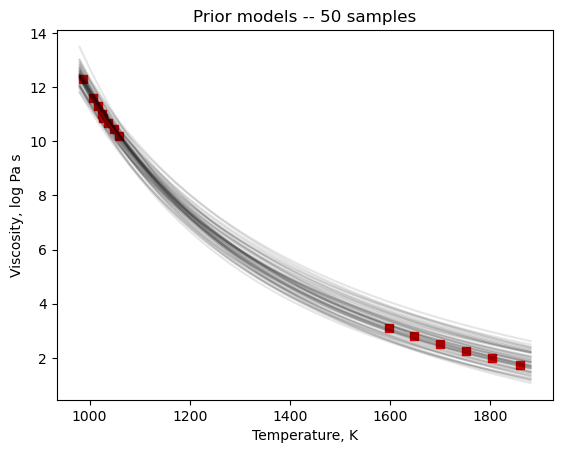

In [18]:
prior_model = idata.prior
import xarray as xr
x = xr.DataArray(temperature_interpolation, dims=["plot_dim"])
prior_y = forward_model(x, prior_model["ae"], prior_model["tg"], prior_model["m"])

plt.plot(data.temperature, data.viscosity,"rs")
plt.plot(x, prior_y.stack(sample=("chain", "draw")), c="k", alpha=0.1)

plt.xlabel("Temperature, K")
plt.ylabel("Viscosity, log Pa s")
plt.title("Prior models -- 50 samples")

We now get samples of the posterior probability distribution using the NUTS algorithm

In [19]:
with basic_model:
    # draw 1000 posterior samples after a tuning step of 1000
    idata = pm.sample(tune=1000, draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ae, tg, m, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


and we can visualize the posterior distributions of the parameters as well as the traces.

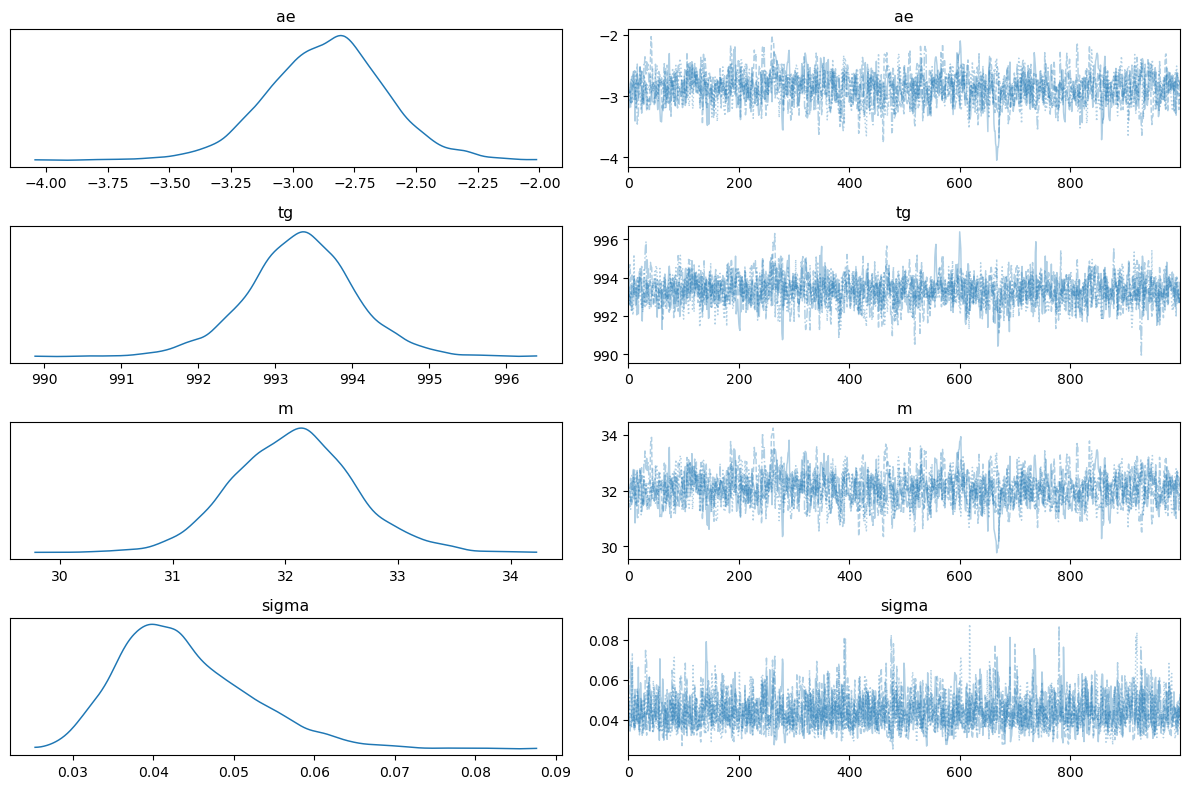

In [20]:
az.plot_trace(idata, combined=True)
plt.tight_layout()

## Now we get some posterior samples

In [21]:
with basic_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)


Sampling: [Y_obs]


Text(0, 0.5, 'Viscosity, log Pa s')

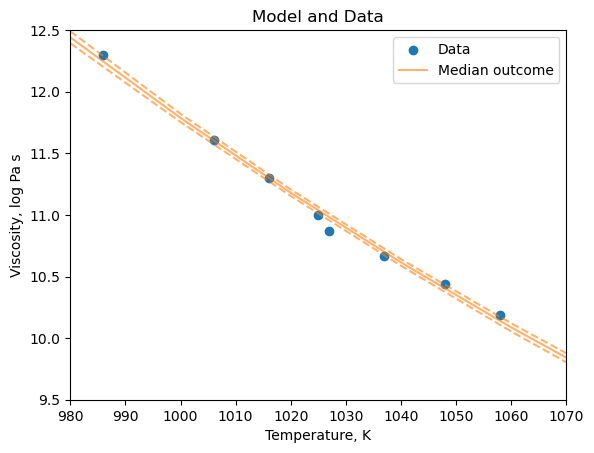

In [22]:
post_model = idata.posterior
post_y = forward_model(x, post_model["ae"], post_model["tg"], post_model["m"])


# plot data
plt.scatter(data.temperature, data.viscosity, label="Data")

# Plot mean model
plt.plot(temperature_interpolation, 
         post_y.quantile(0.5, ("chain", "draw")), label="Median outcome", color="C1", alpha=0.6)

# add legend
plt.legend(loc="best")

# plot the 5 and 95 quantiles = 2sigma confidence intervals
plt.plot(temperature_interpolation, post_y.quantile(0.05,("chain", "draw")), color="C1", linestyle="--", alpha=0.6)
plt.plot(temperature_interpolation, post_y.quantile(0.95,("chain", "draw")), color="C1", linestyle="--", alpha=0.6)

plt.title("Model and Data")
plt.xlim(980, 1070)
plt.ylim(9.5,12.5)
plt.xlabel("Temperature, K")
plt.ylabel("Viscosity, log Pa s")